# Register Layouts & Mappable Registers

In [1]:
import numpy as np

from pulser.register.register_layout import RegisterLayout
from pulser import Sequence, Pulse

One of the strengths of neutral-atom QPUs is their ability to arrange the atoms in arbitrary configurations. Experimentally, this is realized by creating a layout of optical traps where individual atoms can be placed to create the desired Register. 

Given an arbitrary register, a neutral-atom QPU will generate an associated layout that will then have to be calibrated. Each new calibration takes some time, so it is often prefered to reuse an existing layout that has already been calibrated, whenever possible.

Therefore, it can be of interest to the QPU provider to specify which layouts are already calibrated in their QPU, such that the user can reuse them to specify their `Register`. In Pulser, these layouts are provided as instances of the `RegisterLayout` class.

## Arbitrary Layouts

A `RegisterLayout` layout is defined by a set of trap coordinates. These coordinates are systematically ordered in the same way, making two layouts with the same set of trap coordinates identical. 

Below, we create an arbitrary layout of 20 traps randomly placed in a 2D plane. Optionally, a layout may also have an associated `slug` to help identifying it.

In [2]:
# Generating random coordinates
np.random.seed(301122)  # Keeps results consistent between runs
traps = np.random.randint(0, 30, size=(20, 2))
traps = traps - np.mean(traps, axis=0)

# Creating the layout
layout = RegisterLayout(traps, slug="random_20")

Given a `RegisterLayout` instance, the best way to inspect it is through `RegisterLayout.draw()`. Notice the default ordering of the atoms (ascending order in x, if tied then in y, if tied then in z):

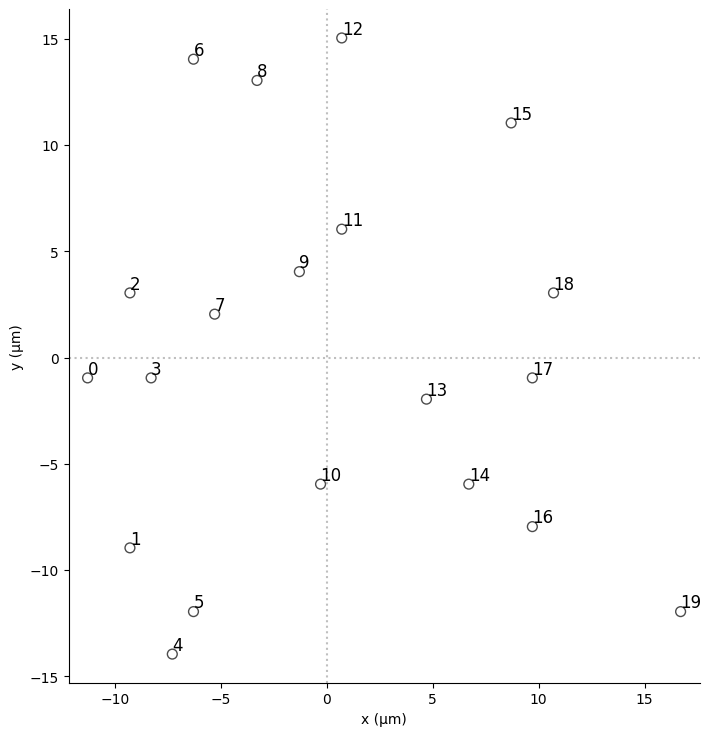

In [3]:
layout.draw()

### Useful properties

To access the trap coordinates:
- `RegisterLayout.traps_dict` gives a mapping between trap IDs and coordinates
- `RegisterLayout.coords` provides the ordered list of trap coordinates

To identify a layout, one can use its `repr()` for a unique identifier or its `str()` for the `slug` (if specified).

In [4]:
print("The layout slug:", layout)
print("The unique ID layout:", repr(layout))

The layout slug: random_20
The unique ID layout: RegisterLayout_0119932f3fc4d0cf580fff471f18baad23e982084be676487841b8a4be41c978


### Register definition

More often than not, a `RegisterLayout` will be created by the hardware provider and given to the user. From there, the user must define the desired `Register` to initialize the `Sequence`. This can be done in multiple ways: 

**1. Defined by the trap IDs:**

You can find the ID of each trap from its drawing or from the `RegisterLayout.traps_dict`. With those, you can define your register (optionally providing a list of qubit IDs):

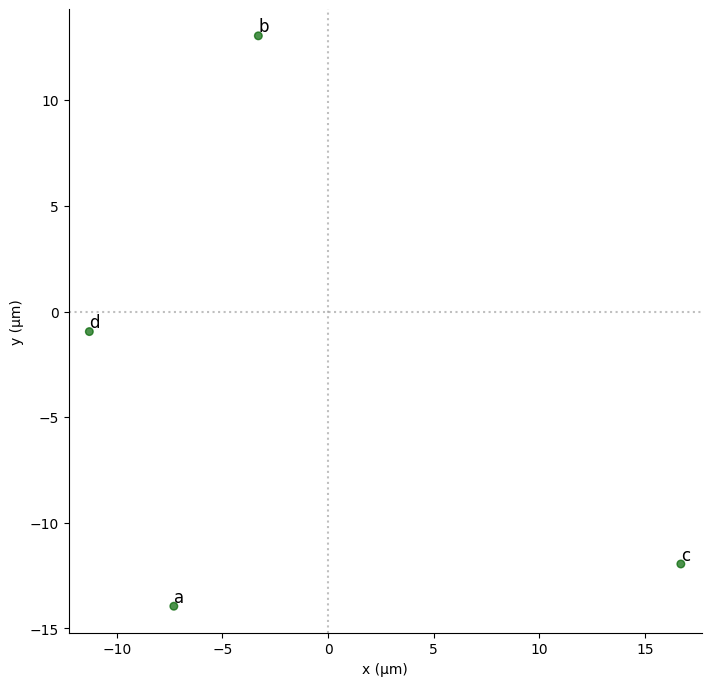

In [5]:
trap_ids = [4, 8, 19, 0]
reg1 = layout.define_register(*trap_ids, qubit_ids=["a", "b", "c", "d"])
reg1.draw()

Note that the information of the layout is stored internally in the Register:

In [6]:
reg1.layout

RegisterLayout_0119932f3fc4d0cf580fff471f18baad23e982084be676487841b8a4be41c978

**2. Defined from the trap coordinates:**

Alternatively, you can find the trap IDs from the trap coordinates using the `RegisterLayout.get_traps_from_coordinates()` method, which compares the provided coordinates with those on the layout with 6 decimal places of precision.

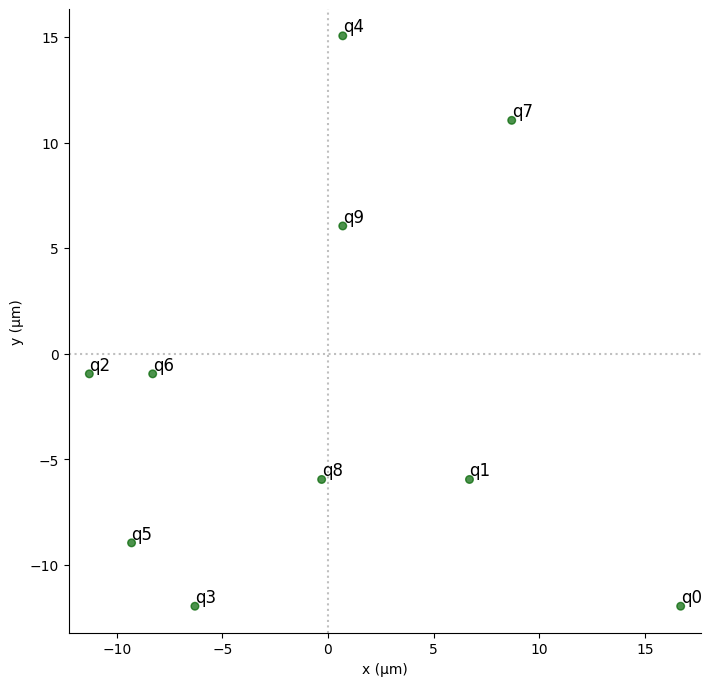

In [7]:
some_coords = layout.coords[
    np.random.choice(np.arange(layout.number_of_traps), size=10, replace=False)
]
trap_ids = layout.get_traps_from_coordinates(*some_coords)
reg2 = layout.define_register(*trap_ids)
reg2.draw()

## Special Layouts

In [8]:
from pulser.register.special_layouts import (
    SquareLatticeLayout,
    TriangularLatticeLayout,
)

On top of the generic `RegisterLayout` class, there are special classes for common layouts that include convenience methods to more easily define a `Register`. These are subclasses of `RegisterLayout`, so all the methods specified above will still work.

### `SquareLatticeLayout`

`SquareLatticeLayout` specifies a layout from an underlying square lattice.

SquareLatticeLayout(7x4, 5.0µm)


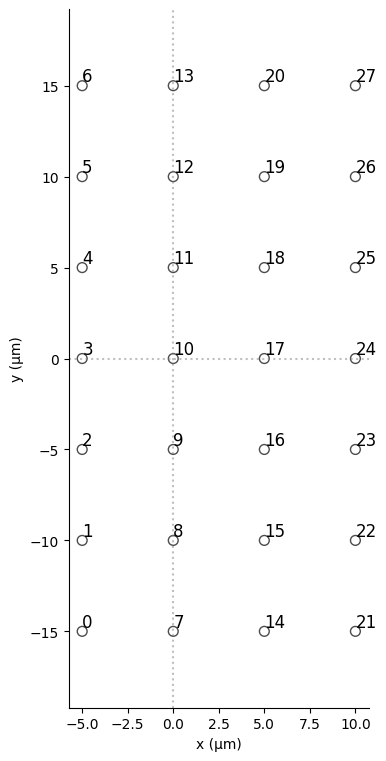

In [9]:
square_layout = SquareLatticeLayout(7, 4, spacing=5)
print(square_layout)
square_layout.draw()

With `SquareLatticeLayout.rectangular_register()` and `SquareLatticeLayout.square_register()`, one can conveniently define a new `Register`:

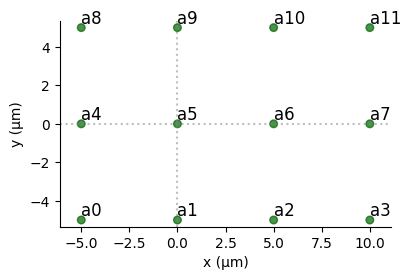

In [10]:
square_layout.rectangular_register(rows=3, columns=4, prefix="a").draw()

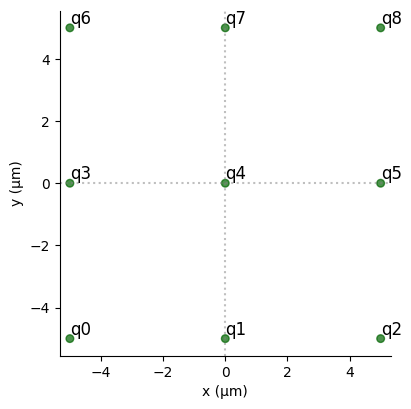

In [11]:
square_layout.square_register(side=3).draw()

### `TriangularLatticeLayout`

`TriangularLatticeLayout` specifies a layout from an underlying triangular lattice.

TriangularLatticeLayout(100, 5.0µm)


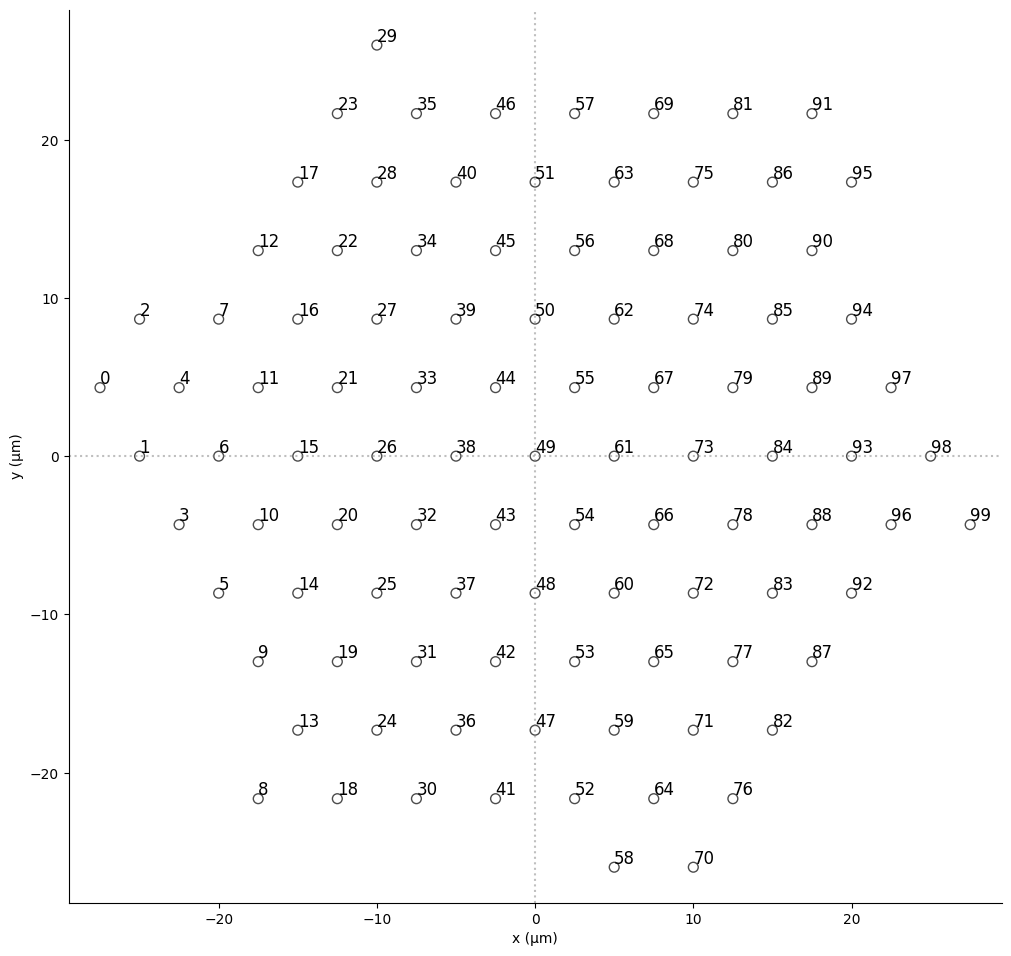

In [12]:
tri_layout = TriangularLatticeLayout(n_traps=100, spacing=5)
print(tri_layout)
tri_layout.draw()

With `TriangularLatticeLayout.hexagonal_register()` or `TriangularLatticeLayout.rectangular_register()`, one can easily define a `Register` from a subset of existing traps.

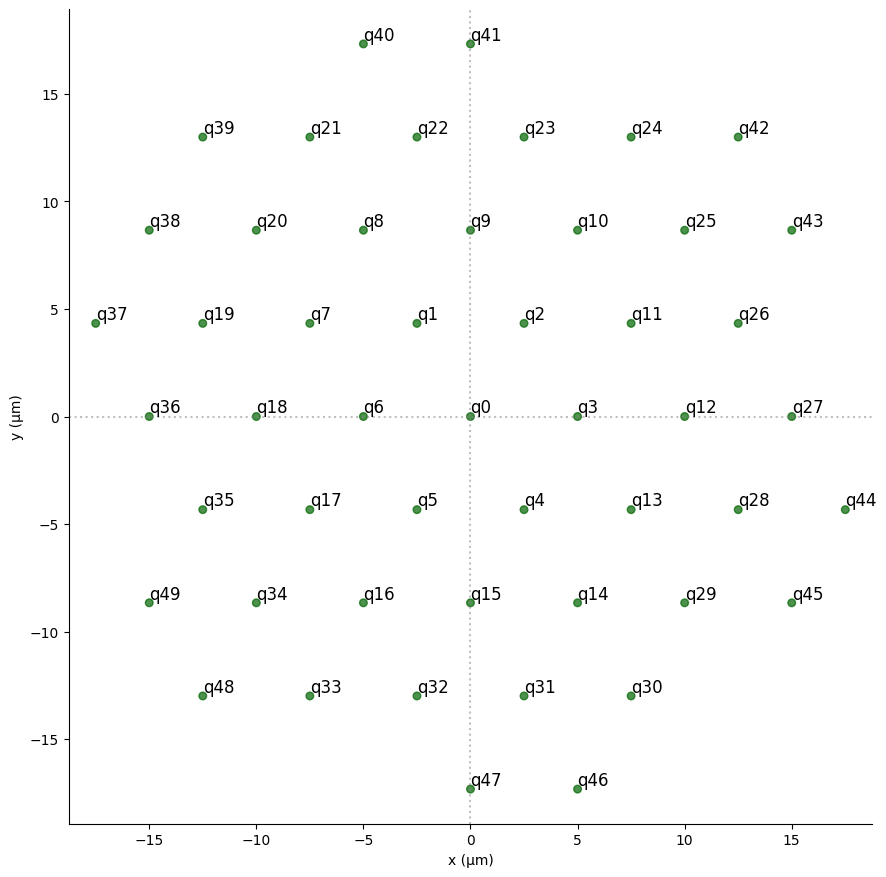

In [13]:
tri_layout.hexagonal_register(n_atoms=50).draw()

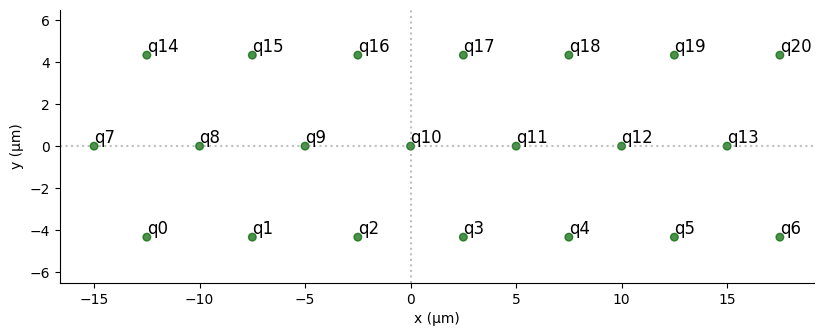

In [14]:
tri_layout.rectangular_register(rows=3, atoms_per_row=7).draw()

## Devices with pre-calibrated layouts

In [15]:
from pulser.devices import Device
from pulser.channels import Rydberg, Raman

TestDevice = Device(
    name="TestDevice",
    dimensions=2,
    rydberg_level=70,
    max_atom_num=100,
    max_radial_distance=50,
    max_layout_filling=0.4,
    min_atom_distance=4,
    channel_objects=(Rydberg.Global(2 * np.pi * 20, 2 * np.pi * 2.5),),
    pre_calibrated_layouts=(
        SquareLatticeLayout(10, 10, 4),
        TriangularLatticeLayout(100, 5),
    ),
)

When receiving a `Device` instance, it may include the layouts that are already calibrated and available to be used. To access them, simply run:

In [16]:
TestDevice.calibrated_register_layouts

{'SquareLatticeLayout(10x10, 4.0µm)': RegisterLayout_e0a40bea81ea9f3ef63dfbb16ee1fa85138e50a9402b1fa04822994b055c0b4f,
 'TriangularLatticeLayout(100, 5.0µm)': RegisterLayout_46d398a85ffbed2af2918ecfc59fe0ab265ee3ffdea3d734774bee2fc5c90145}

You can then choose one of these layouts to define your `Register` and start creating a `Sequence`:

In [17]:
layout = TestDevice.calibrated_register_layouts[
    "SquareLatticeLayout(10x10, 4.0µm)"
]
reg = layout.square_register(6)
seq = Sequence(reg, TestDevice)

In general, when a device comes with `pre_calibrated_layouts`, using them is encouraged. However, nothing prevents a `Sequence` to be created with a register coming from another layout, as long as that layout is compatible with the device. For example:

In [18]:
another_layout = SquareLatticeLayout(5, 5, 5)
assert another_layout not in TestDevice.pre_calibrated_layouts
reg_ = another_layout.square_register(3)
seq = Sequence(reg_, TestDevice)

However, it is not possible to use a register created from an invalid layout, even if the register is valid:

In [19]:
bad_layout = TriangularLatticeLayout(
    200, 10
)  # This layout is too large for TestDevice
good_reg = bad_layout.hexagonal_register(
    10
)  # On its own, this register is valid in TestDevice
try:
    seq = Sequence(good_reg, TestDevice)
except ValueError as e:
    print(e)

The 'register' is associated with an incompatible register layout.


### Maximum Layout Filling Fraction

Through the `Device.max_layout_filling`, a device also specifies how much a layout can be filled. Although the default value is 0.5, some devices might have slightly higher or lower values. 

In the case of our `TestDevice`, we specified the maximum layout filling fraction to be 0.4 . This means that we can use up to 40% of a `RegisterLayout` to form our register.

Let us see what would happen if we were to go over this value (e.g. by making a register of 49 atoms from a layout with 100 atoms):

In [20]:
layout = TestDevice.calibrated_register_layouts[
    "SquareLatticeLayout(10x10, 4.0µm)"
]
too_big_reg = layout.square_register(7)
try:
    seq = Sequence(too_big_reg, TestDevice)
except ValueError as e:
    print(e)

Given the number of traps in the layout and the device's maximum layout filling fraction, the given register has too many qubits (49). On this device, this layout can hold at most 40 qubits.


## Mappable Registers

Finally, layouts enable the creation of a `MappableRegister` — a register with the traps of each qubit still to be defined. This register can then be used to create a sort of parametrized `Sequence`, where deciding which traps will be mapped to which qubits only happens when `Sequence.build()` is called.

For example, below we define a mappable register with 10 qubits.

In [21]:
map_register = layout.make_mappable_register(n_qubits=10)
map_register.qubit_ids

('q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9')

We now use this register in our simple sequence:

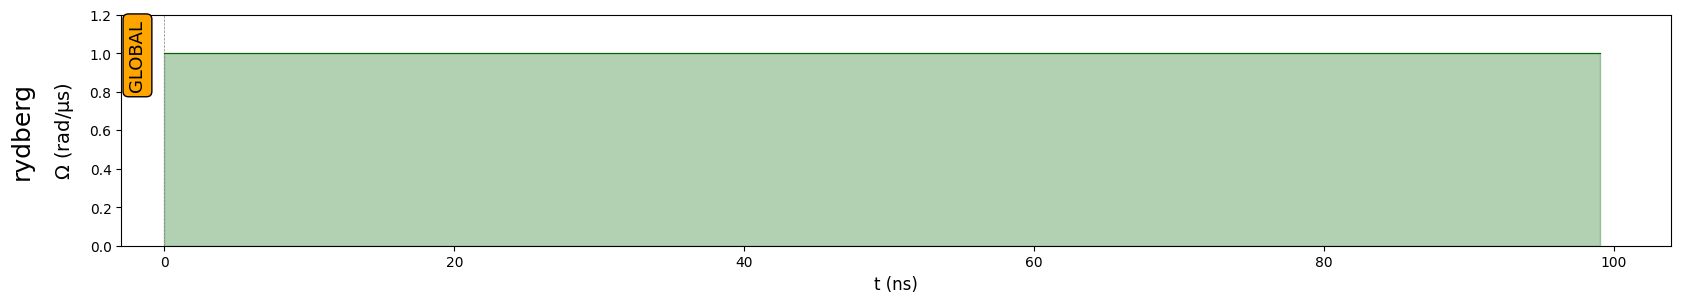

In [22]:
seq = Sequence(map_register, TestDevice)
assert seq.is_register_mappable()

seq.declare_channel("rydberg", "rydberg_global")
seq.add(
    Pulse.ConstantPulse(duration=100, amplitude=1, detuning=0, phase=0),
    "rydberg",
)
seq.draw()

To define the register, we can then call `Sequence.build()`, indicating in the `qubits` argument the map between qubit IDs and trap IDs. Note that not all the qubit IDs need to be associated to a trap ID, and that the qubit IDs have to be defined in their order of appearance in `MappableRegister.qubit_ids` (it is not possible to associate a trap ID to qubit ID "q4" if no trap ID was assigned to qubit ID "q3").

In this way, we can build multiple sequences, with only the `Register` changing from one to the other:

In [23]:
seq1 = seq.build(qubits={"q0": 16, "q1": 19, "q2": 34})
print("First register:", seq1.register.qubits)

seq2 = seq.build(qubits={"q0": 0, "q2": 15, "q1": 20, "q3": 50})
print("Second register:", seq2.register.qubits)

First register: {'q0': array([-12.,   8.]), 'q1': array([-12.,  20.]), 'q2': array([-4.,  0.])}
Second register: {'q0': array([-16., -16.]), 'q1': array([ -8., -16.]), 'q2': array([-12.,   4.]), 'q3': array([  4., -16.])}
